In [1]:
import numpy as np
import imageio
import scipy
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from PIL import Image
from itertools                  import product
from sklearn.metrics import accuracy_score

2023-08-15 16:10:10.148136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
TRAIN_DIR = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/grocery_store/GroceryStoreDataset/dataset/train'
TEST_DIR = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/grocery_store/GroceryStoreDataset/dataset/test'
VALIDATION_DIR = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/grocery_store/GroceryStoreDataset/dataset/val'

batch_size = 32
img_size = 224


In [3]:
training_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="training",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

test_set = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    subset="validation",
    validation_split=0.2,
    seed=100,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

Found 5799 files belonging to 56 classes.
Using 4640 files for training.
Found 2835 files belonging to 56 classes.
Found 5799 files belonging to 56 classes.
Using 1159 files for validation.


In [4]:
test_class_names = test_set.class_names
list(map(str.lower, test_class_names))

['apple',
 'asparagus',
 'aubergine',
 'avocado',
 'banana',
 'beans',
 'beetroot',
 'cabbage',
 'carrots',
 'cauliflower',
 'corn',
 'cucumber',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'juice',
 'kiwi',
 'leek',
 'lemon',
 'lettuce',
 'lime',
 'mango',
 'melon',
 'milk',
 'mushroom',
 'nectarine',
 'oat-milk',
 'oatghurt',
 'onion',
 'orange',
 'papaya',
 'passion-fruit',
 'peach',
 'pear',
 'peas',
 'pepper',
 'pineapple',
 'plum',
 'pomegranate',
 'potato',
 'raddish',
 'red-beet',
 'red-grapefruit',
 'satsumas',
 'sour-cream',
 'sour-milk',
 'soy-milk',
 'soyghurt',
 'spinach',
 'table',
 'tomato',
 'turnip',
 'watermelon',
 'yoghurt',
 'zucchini']

In [5]:
training_set


<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
# X_train = np.array([])
# for x, y in training_set:
#     X_train = np.concatenate([x]) 

# X_test = np.array([])
# for x, y in test_set:
#     X_test = np.concatenate([x]) 

# X_validation = np.array([])
# for x, y in training_set:
#     X_validation = np.concatenate([x])  

In [7]:
y_train = training_set.class_names
y_test = test_set.class_names
y_validation = validation_set.class_names

In [8]:
set(y_train) - set(y_test)

set()

In [9]:
# all photos train

# num_rows = 4  
# num_cols = 4  
# total_images = len(training_set) * batch_size

# num_plots = (total_images + num_rows * num_cols - 1) // (num_rows * num_cols)

# for plot_index in range(num_plots):
#     plt.figure(figsize=(15, 15))
    
#     for batch_images, batch_labels in training_set.skip(plot_index).take(1):
#         for i in range(num_rows * num_cols):
#             image_index = plot_index * num_rows * num_cols + i
#             if image_index >= total_images:
#                 break
            
#             plt.subplot(num_rows, num_cols, i + 1)
#             plt.imshow(batch_images[i].numpy().astype("uint8"))
#             plt.title(class_names[batch_labels[i]])
#             plt.axis("off")
    
#     plt.tight_layout()
#     plt.show()

In [10]:
# num_rows = 4
# num_cols = 4
# plt.figure(figsize=(15, 15))

# for images, labels in training_set.take(1): 
#     for i in range(num_rows * num_cols):
#         plt.subplot(num_rows, num_cols, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(y_train[labels[i]])
#         plt.axis("off")

# plt.tight_layout()
# plt.show()

In [11]:
# X_train.shape, X_validation.shape, X_test.shape

In [12]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
base_model.trainable = False

In [13]:
inputs_layer = tf.keras.Input(shape=(img_size, img_size, 3))

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs_layer)

x = tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal")(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)(x)

# x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
# x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

outputs_layer = tf.keras.layers.Dense(units=len(training_set.class_names), activation='softmax')(x)

In [14]:
model = tf.keras.Model(inputs=inputs_layer, outputs=outputs_layer, name="photo2ingredients")

In [15]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

In [16]:
model.summary()

Model: "photo2ingredients"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                          

In [17]:
history = model.fit(x=training_set,
                    epochs=6,
                    validation_data=validation_set
                    # callbacks=[tf.keras.callbacks.EarlyStopping(patience=50, verbose=1, restore_best_weights=True)]
                    )

Epoch 1/6


2023-08-15 16:10:17.208368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4640]
	 [[{{node Placeholder/_4}}]]
2023-08-15 16:10:17.209222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4640]
	 [[{{node Placeholder/_4}}]]
2023-08-15 16:10:20.535372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:10:22.081799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 16:33 - loss: 4.2513 - accuracy: 0.0000e+00

2023-08-15 16:10:24.261725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:45 - loss: 3.8200 - accuracy: 0.1437

2023-08-15 16:10:27.558799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/145 [=>............................] - ETA: 1:37 - loss: 3.4155 - accuracy: 0.2159

2023-08-15 16:10:31.399904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:26 - loss: 2.7136 - accuracy: 0.3613

2023-08-15 16:10:41.424741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:25 - loss: 2.5853 - accuracy: 0.3828

2023-08-15 16:10:43.887855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:20 - loss: 2.2924 - accuracy: 0.4476

2023-08-15 16:10:51.227686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:18 - loss: 2.2017 - accuracy: 0.4673

2023-08-15 16:10:57.724727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/145 [============>.................] - ETA: 59s - loss: 1.9351 - accuracy: 0.5123

2023-08-15 16:11:12.595175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/145 [===============>..............] - ETA: 50s - loss: 1.8420 - accuracy: 0.5337

2023-08-15 16:11:21.761132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/145 [================>.............] - ETA: 46s - loss: 1.7866 - accuracy: 0.5454

2023-08-15 16:11:27.735783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 37s - loss: 1.6728 - accuracy: 0.5680

2023-08-15 16:11:39.226304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/145 [===================>..........] - ETA: 36s - loss: 1.6557 - accuracy: 0.5713

2023-08-15 16:11:41.128777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/145 [====================>.........] - ETA: 34s - loss: 1.6367 - accuracy: 0.5744

2023-08-15 16:11:44.264060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/145 [====================>.........] - ETA: 33s - loss: 1.6264 - accuracy: 0.5771

2023-08-15 16:11:45.362293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/145 [=====================>........] - ETA: 29s - loss: 1.5954 - accuracy: 0.5833

2023-08-15 16:11:49.231282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/145 [=====================>........] - ETA: 27s - loss: 1.5774 - accuracy: 0.5867

2023-08-15 16:11:51.446680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 24s - loss: 1.5691 - accuracy: 0.5883

2023-08-15 16:11:53.807964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/145 [=======================>......] - ETA: 22s - loss: 1.5586 - accuracy: 0.5911

2023-08-15 16:11:55.018266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 1.4509 - accuracy: 0.6123

2023-08-15 16:12:15.529309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1159]
	 [[{{node Placeholder/_4}}]]
2023-08-15 16:12:15.530226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1159]
	 [[{{node Placeholder/_0}}]]
2023-08-15 16:12:17.892607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:12:29.431818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:12:30.389774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: 

145/145 [==============================] - 145s 960ms/step - loss: 1.4509 - accuracy: 0.6123 - val_loss: 0.8449 - val_accuracy: 0.7481
Epoch 2/6


2023-08-15 16:12:42.538645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:12:44.312248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 9:02 - loss: 0.6006 - accuracy: 0.8125

2023-08-15 16:12:46.268818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:43 - loss: 0.7413 - accuracy: 0.7688

2023-08-15 16:12:49.483805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/145 [=>............................] - ETA: 1:36 - loss: 0.7311 - accuracy: 0.7614

2023-08-15 16:12:53.347696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:25 - loss: 0.6812 - accuracy: 0.7850

2023-08-15 16:13:03.283087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:24 - loss: 0.6599 - accuracy: 0.7935

2023-08-15 16:13:05.660114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:22 - loss: 0.6403 - accuracy: 0.7948

2023-08-15 16:13:13.845290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:16 - loss: 0.6516 - accuracy: 0.7940

2023-08-15 16:13:18.641753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/145 [============>.................] - ETA: 1:01 - loss: 0.6862 - accuracy: 0.7831

2023-08-15 16:13:36.713627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/145 [===============>..............] - ETA: 52s - loss: 0.6770 - accuracy: 0.7877

2023-08-15 16:13:46.505967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/145 [================>.............] - ETA: 47s - loss: 0.6659 - accuracy: 0.7898

2023-08-15 16:13:50.874543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 36s - loss: 0.6567 - accuracy: 0.7941

2023-08-15 16:13:59.387650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/145 [===================>..........] - ETA: 34s - loss: 0.6556 - accuracy: 0.7942

2023-08-15 16:14:00.662737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/145 [====================>.........] - ETA: 32s - loss: 0.6520 - accuracy: 0.7956

2023-08-15 16:14:02.721649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/145 [====================>.........] - ETA: 31s - loss: 0.6512 - accuracy: 0.7964

2023-08-15 16:14:03.643745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/145 [=====================>........] - ETA: 27s - loss: 0.6482 - accuracy: 0.7980

2023-08-15 16:14:06.999748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/145 [=====================>........] - ETA: 25s - loss: 0.6520 - accuracy: 0.7976

2023-08-15 16:14:08.731890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 23s - loss: 0.6519 - accuracy: 0.7980

2023-08-15 16:14:10.934308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/145 [=======================>......] - ETA: 21s - loss: 0.6504 - accuracy: 0.7982

2023-08-15 16:14:12.507221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.8050

2023-08-15 16:14:34.687408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:14:46.231336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:14:47.064000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - 137s 922ms/step - loss: 0.6320 - accuracy: 0.8050 - val_loss: 0.6403 - val_accuracy: 0.8041
Epoch 3/6


2023-08-15 16:14:59.126645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:15:00.997468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 9:42 - loss: 0.6296 - accuracy: 0.8125

2023-08-15 16:15:03.208006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:49 - loss: 0.4342 - accuracy: 0.8562

2023-08-15 16:15:06.690051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/145 [=>............................] - ETA: 1:40 - loss: 0.4155 - accuracy: 0.8608

2023-08-15 16:15:10.487906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:38 - loss: 0.4627 - accuracy: 0.8537

2023-08-15 16:15:22.651207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:35 - loss: 0.4612 - accuracy: 0.8527

2023-08-15 16:15:25.097936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:25 - loss: 0.4801 - accuracy: 0.8446

2023-08-15 16:15:31.839164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:19 - loss: 0.4921 - accuracy: 0.8423

2023-08-15 16:15:36.678691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/145 [============>.................] - ETA: 1:02 - loss: 0.4986 - accuracy: 0.8428

2023-08-15 16:15:54.974452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/145 [===============>..............] - ETA: 53s - loss: 0.4810 - accuracy: 0.8502

2023-08-15 16:16:04.391941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/145 [================>.............] - ETA: 48s - loss: 0.4753 - accuracy: 0.8512

2023-08-15 16:16:08.469339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 37s - loss: 0.4661 - accuracy: 0.8541

2023-08-15 16:16:18.434899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/145 [===================>..........] - ETA: 36s - loss: 0.4669 - accuracy: 0.8539

2023-08-15 16:16:20.110751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/145 [====================>.........] - ETA: 33s - loss: 0.4641 - accuracy: 0.8545

2023-08-15 16:16:22.660336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/145 [====================>.........] - ETA: 33s - loss: 0.4641 - accuracy: 0.8547

2023-08-15 16:16:23.594326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/145 [=====================>........] - ETA: 29s - loss: 0.4614 - accuracy: 0.8550

2023-08-15 16:16:27.299624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/145 [=====================>........] - ETA: 26s - loss: 0.4591 - accuracy: 0.8556

2023-08-15 16:16:29.094841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 24s - loss: 0.4577 - accuracy: 0.8564

2023-08-15 16:16:31.596507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/145 [=======================>......] - ETA: 22s - loss: 0.4568 - accuracy: 0.8564

2023-08-15 16:16:33.064633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.8644

2023-08-15 16:16:53.682359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:17:04.826222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:17:05.839839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - 138s 929ms/step - loss: 0.4362 - accuracy: 0.8644 - val_loss: 0.5100 - val_accuracy: 0.8628
Epoch 4/6


2023-08-15 16:17:16.902319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:17:18.687734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 8:43 - loss: 0.4570 - accuracy: 0.8438

2023-08-15 16:17:20.471361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:30 - loss: 0.3105 - accuracy: 0.9125

2023-08-15 16:17:23.179068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/145 [=>............................] - ETA: 1:28 - loss: 0.2999 - accuracy: 0.8949

2023-08-15 16:17:26.948838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:26 - loss: 0.3338 - accuracy: 0.8875

2023-08-15 16:17:37.613799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:23 - loss: 0.3234 - accuracy: 0.8895

2023-08-15 16:17:39.626251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:16 - loss: 0.3610 - accuracy: 0.8809

2023-08-15 16:17:45.893721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:10 - loss: 0.3732 - accuracy: 0.8764

2023-08-15 16:17:50.391837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/145 [============>.................] - ETA: 57s - loss: 0.3786 - accuracy: 0.8736

2023-08-15 16:18:08.946891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/145 [==============>...............] - ETA: 50s - loss: 0.3701 - accuracy: 0.8795

2023-08-15 16:18:16.939349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/145 [================>.............] - ETA: 46s - loss: 0.3721 - accuracy: 0.8791

2023-08-15 16:18:21.249939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/145 [==================>...........] - ETA: 36s - loss: 0.3813 - accuracy: 0.8766

2023-08-15 16:18:29.621779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 35s - loss: 0.3807 - accuracy: 0.8763

2023-08-15 16:18:31.045636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/145 [===================>..........] - ETA: 33s - loss: 0.3797 - accuracy: 0.8766

2023-08-15 16:18:33.148016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/145 [===================>..........] - ETA: 32s - loss: 0.3789 - accuracy: 0.8769

2023-08-15 16:18:33.940356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/145 [====================>.........] - ETA: 28s - loss: 0.3813 - accuracy: 0.8768

2023-08-15 16:18:37.119952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/145 [=====================>........] - ETA: 26s - loss: 0.3776 - accuracy: 0.8787

2023-08-15 16:18:38.683116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/145 [======================>.......] - ETA: 23s - loss: 0.3768 - accuracy: 0.8783

2023-08-15 16:18:40.893928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 22s - loss: 0.3770 - accuracy: 0.8777

2023-08-15 16:18:42.153405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 0.3741 - accuracy: 0.8802

2023-08-15 16:19:01.881838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:19:11.769338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:19:12.496244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - 126s 849ms/step - loss: 0.3741 - accuracy: 0.8802 - val_loss: 0.5435 - val_accuracy: 0.8499
Epoch 5/6


2023-08-15 16:19:22.924116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:19:24.590931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 8:41 - loss: 0.1579 - accuracy: 0.9688

2023-08-15 16:19:26.466756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:35 - loss: 0.2253 - accuracy: 0.9312

2023-08-15 16:19:29.373596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/145 [=>............................] - ETA: 1:31 - loss: 0.2509 - accuracy: 0.9219

2023-08-15 16:19:32.363870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:20 - loss: 0.2868 - accuracy: 0.9050

2023-08-15 16:19:42.369980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:18 - loss: 0.2883 - accuracy: 0.9029

2023-08-15 16:19:44.378189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:11 - loss: 0.3131 - accuracy: 0.8953

2023-08-15 16:19:50.392554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:06 - loss: 0.3205 - accuracy: 0.8956

2023-08-15 16:19:54.663360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/145 [============>.................] - ETA: 52s - loss: 0.3032 - accuracy: 0.9020

2023-08-15 16:20:09.498602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/145 [===============>..............] - ETA: 44s - loss: 0.3078 - accuracy: 0.8990

2023-08-15 16:20:17.900832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/145 [================>.............] - ETA: 40s - loss: 0.3050 - accuracy: 0.8999

2023-08-15 16:20:21.879108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 31s - loss: 0.3090 - accuracy: 0.8995

2023-08-15 16:20:30.166803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/145 [===================>..........] - ETA: 30s - loss: 0.3171 - accuracy: 0.8974

2023-08-15 16:20:31.562386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/145 [====================>.........] - ETA: 28s - loss: 0.3170 - accuracy: 0.8977

2023-08-15 16:20:33.684251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/145 [====================>.........] - ETA: 27s - loss: 0.3157 - accuracy: 0.8978

2023-08-15 16:20:34.468174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/145 [=====================>........] - ETA: 24s - loss: 0.3208 - accuracy: 0.8967

2023-08-15 16:20:37.919322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/145 [=====================>........] - ETA: 22s - loss: 0.3169 - accuracy: 0.8981

2023-08-15 16:20:39.600060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 20s - loss: 0.3165 - accuracy: 0.8983

2023-08-15 16:20:41.864865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/145 [=======================>......] - ETA: 19s - loss: 0.3174 - accuracy: 0.8976

2023-08-15 16:20:43.120805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 0.3143 - accuracy: 0.8983

2023-08-15 16:21:02.275453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:21:12.675422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:21:13.470667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - 121s 816ms/step - loss: 0.3143 - accuracy: 0.8983 - val_loss: 0.5228 - val_accuracy: 0.8568
Epoch 6/6


2023-08-15 16:21:24.034722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:21:25.706855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/145 [..............................] - ETA: 8:37 - loss: 0.1788 - accuracy: 0.9062

2023-08-15 16:21:27.657138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/145 [>.............................] - ETA: 1:41 - loss: 0.2354 - accuracy: 0.9312

2023-08-15 16:21:30.698794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/145 [=>............................] - ETA: 1:30 - loss: 0.2624 - accuracy: 0.9119

2023-08-15 16:21:34.226645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/145 [====>.........................] - ETA: 1:20 - loss: 0.2147 - accuracy: 0.9312

2023-08-15 16:21:43.633437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/145 [====>.........................] - ETA: 1:19 - loss: 0.2068 - accuracy: 0.9342

2023-08-15 16:21:45.728188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/145 [======>.......................] - ETA: 1:12 - loss: 0.2284 - accuracy: 0.9248

2023-08-15 16:21:52.041525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/145 [========>.....................] - ETA: 1:07 - loss: 0.2448 - accuracy: 0.9219

2023-08-15 16:21:56.386686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/145 [============>.................] - ETA: 53s - loss: 0.2582 - accuracy: 0.9149

2023-08-15 16:22:10.400316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/145 [===============>..............] - ETA: 44s - loss: 0.2646 - accuracy: 0.9111

2023-08-15 16:22:18.799613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/145 [================>.............] - ETA: 40s - loss: 0.2598 - accuracy: 0.9137

2023-08-15 16:22:23.202584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/145 [===================>..........] - ETA: 32s - loss: 0.2623 - accuracy: 0.9124

2023-08-15 16:22:32.208367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/145 [===================>..........] - ETA: 31s - loss: 0.2606 - accuracy: 0.9122

2023-08-15 16:22:33.609459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/145 [====================>.........] - ETA: 29s - loss: 0.2604 - accuracy: 0.9127

2023-08-15 16:22:35.703136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/145 [====================>.........] - ETA: 28s - loss: 0.2597 - accuracy: 0.9129

2023-08-15 16:22:36.437838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/145 [=====================>........] - ETA: 24s - loss: 0.2568 - accuracy: 0.9129

2023-08-15 16:22:39.770522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/145 [=====================>........] - ETA: 22s - loss: 0.2541 - accuracy: 0.9139

2023-08-15 16:22:41.446866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/145 [======================>.......] - ETA: 20s - loss: 0.2569 - accuracy: 0.9126

2023-08-15 16:22:43.748871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/145 [=======================>......] - ETA: 19s - loss: 0.2542 - accuracy: 0.9138

2023-08-15 16:22:44.946953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.9142

2023-08-15 16:23:04.019992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:23:14.395234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-08-15 16:23:15.173573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/145 [==============================] - 122s 821ms/step - loss: 0.2486 - accuracy: 0.9142 - val_loss: 0.5099 - val_accuracy: 0.8576


In [18]:
predictions = model.predict(test_set, verbose=1)

2023-08-15 16:23:25.717215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2835]
	 [[{{node Placeholder/_0}}]]
2023-08-15 16:23:25.717737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2835]
	 [[{{node Placeholder/_4}}]]


 6/89 [=>............................] - ETA: 42s

2023-08-15 16:23:31.228138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/89 [=========>....................] - ETA: 30s

2023-08-15 16:23:44.808243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


89/89 [==============================] - 49s 531ms/step


In [19]:
test_class_names = test_set.class_names

In [20]:
labels_array = np.array([])
pred_array = np.array([])

for x, y in test_set.take(1):
    pred_prob = model.predict(x)
    labels_array = np.concatenate([labels_array, y])
    pred_class = np.argmax(pred_prob, axis=1)
    pred_array = np.concatenate([pred_array, pred_class])    
    
print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))

2023-08-15 16:24:48.729952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2835]
	 [[{{node Placeholder/_4}}]]
2023-08-15 16:24:48.731236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2835]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 1s 1s/step
Accuracy On Test Dataset:  0.75


In [21]:
def plot_graghs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

2023-08-15 16:24:51.583042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2835]
	 [[{{node Placeholder/_0}}]]
2023-08-15 16:24:51.583607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2835]
	 [[{{node Placeholder/_4}}]]


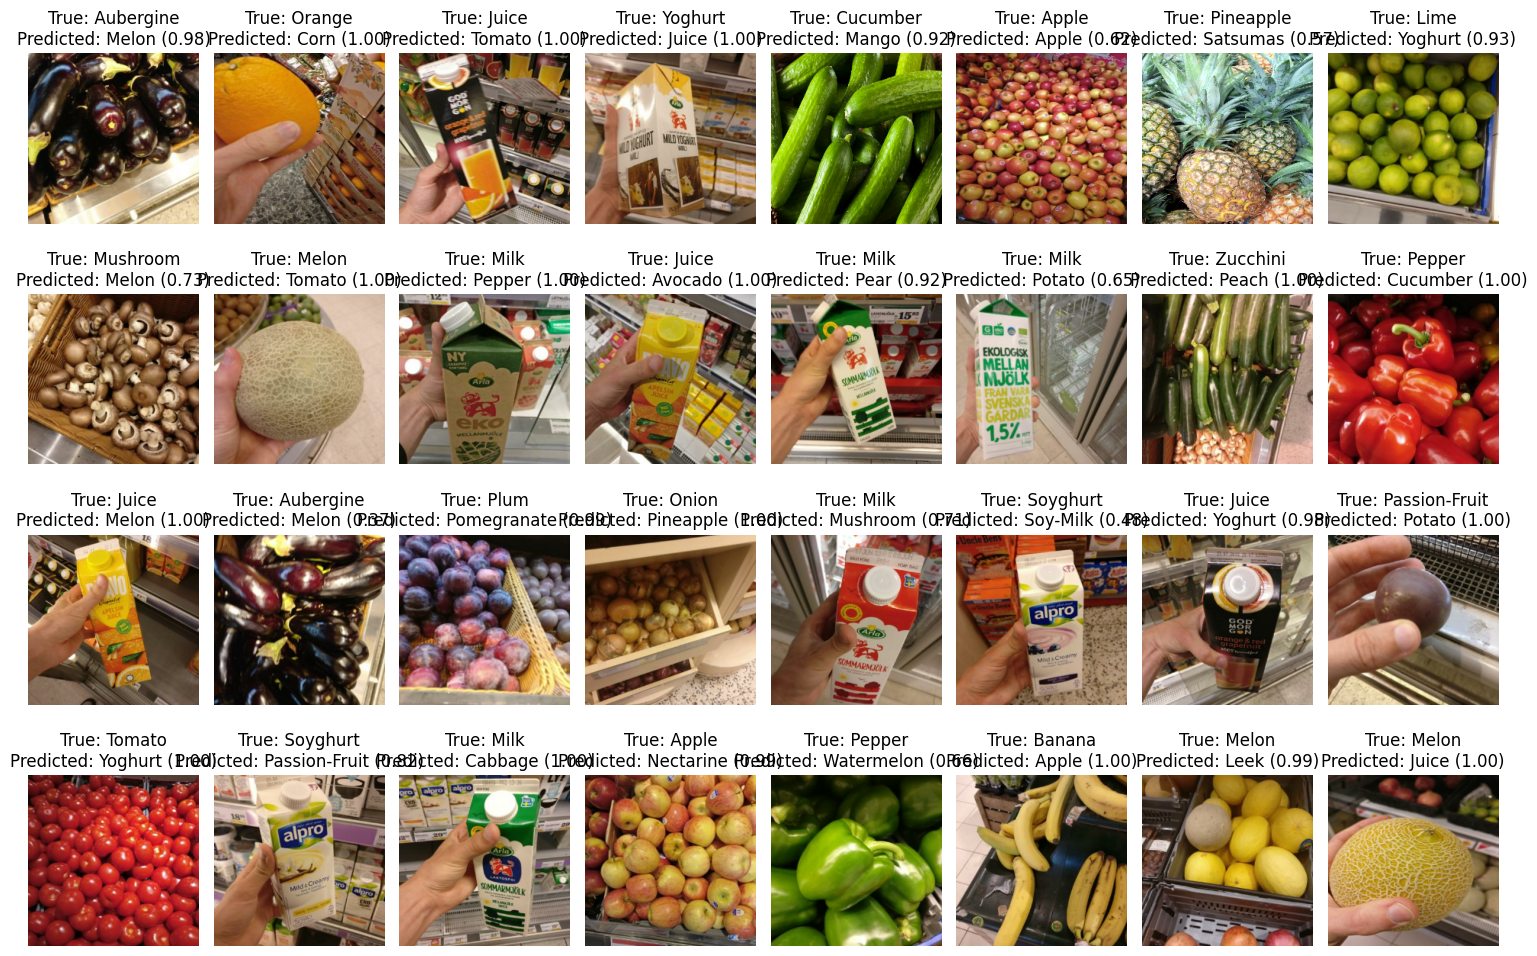

In [22]:
plt.figure(figsize=(15, 10))
for images, labels in test_set.take(1):
    for i in range(len(images)):
        plt.subplot(4, 8, i + 1)  # Adjust the subplot layout based on your batch size
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class = np.argmax(predictions[i])
        confidence = predictions[i][predicted_class]
        true_class = test_class_names[labels[i]]
        predicted_class_name = test_class_names[predicted_class]
        plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
        plt.axis('off')
plt.tight_layout()
plt.show()

1/1 [==============================] - 1s 516ms/step


2023-08-15 16:25:01.475376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 479ms/step


2023-08-15 16:25:15.515377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 472ms/step


/var/folders/sh/41fnk4317z18sxj_vwp76hz40000gn/T/ipykernel_3709/3596122770.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


1/1 [==============================] - 1s 924ms/step


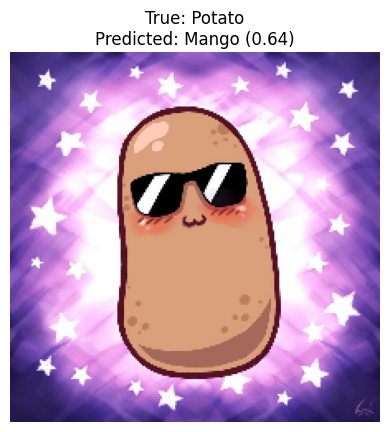

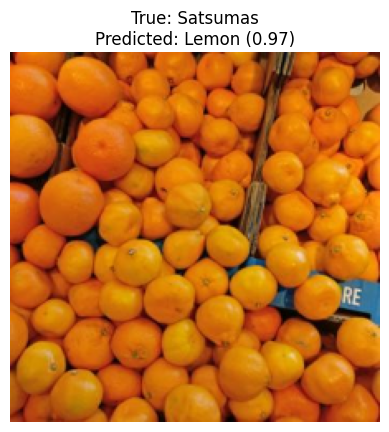

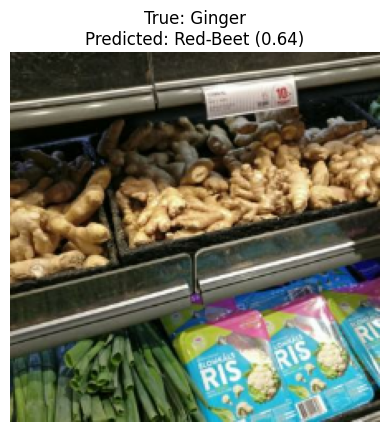

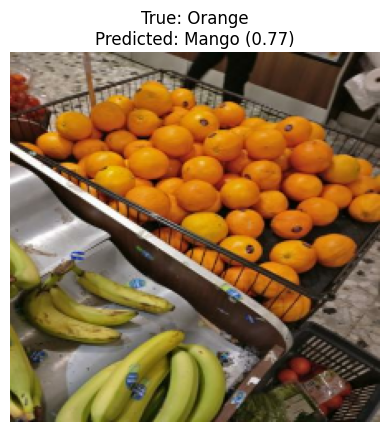

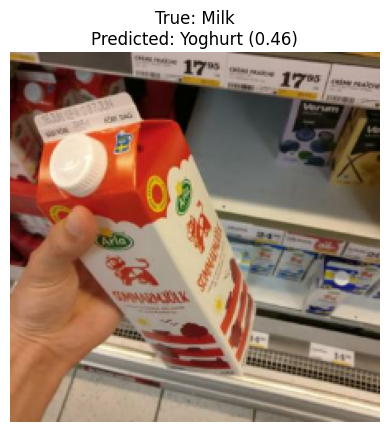

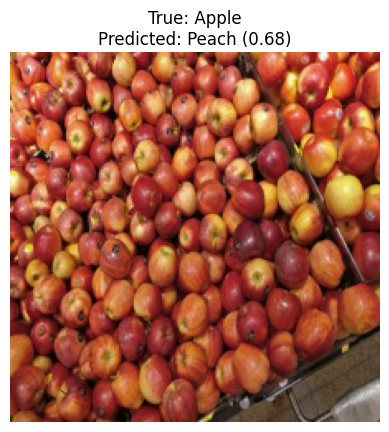

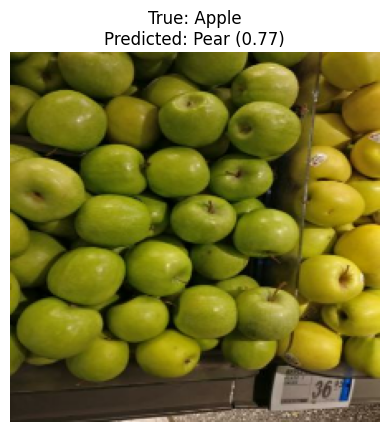

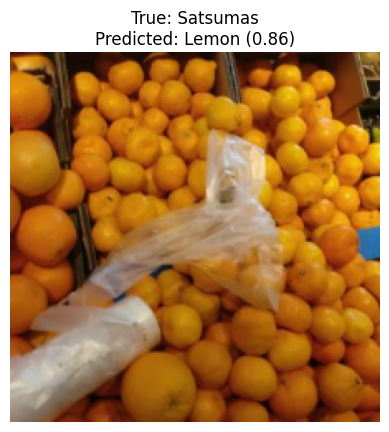

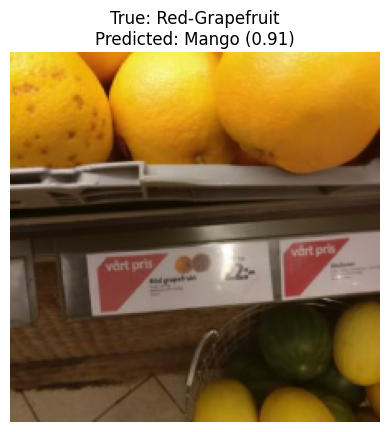

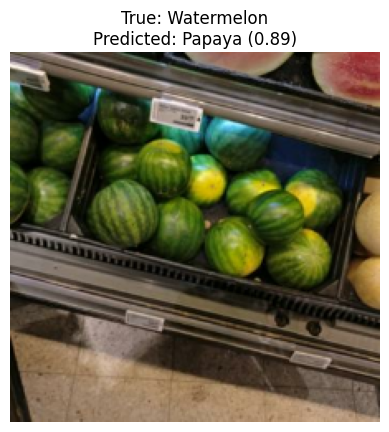

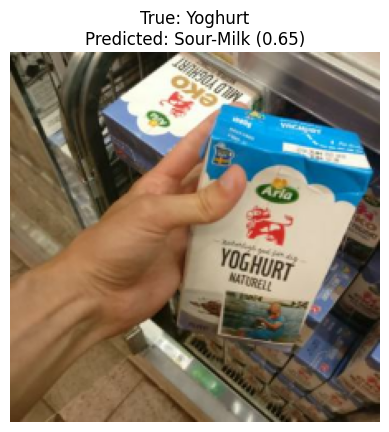

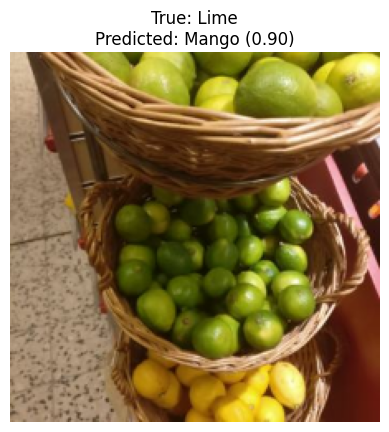

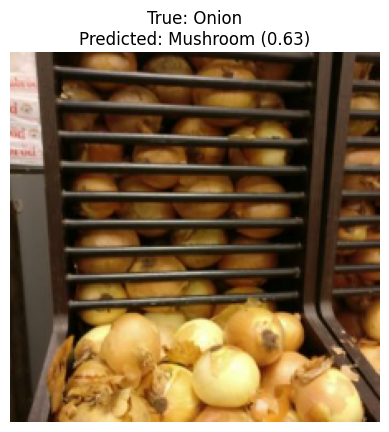

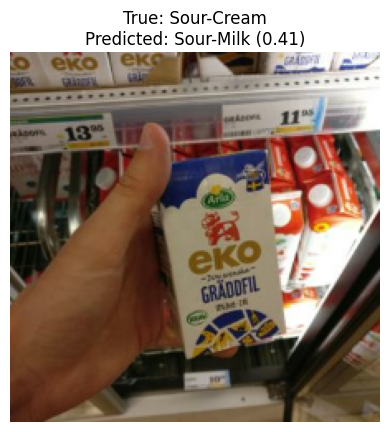

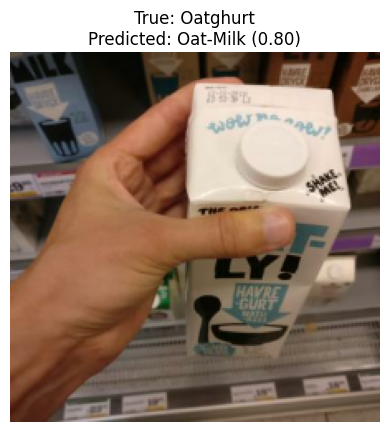

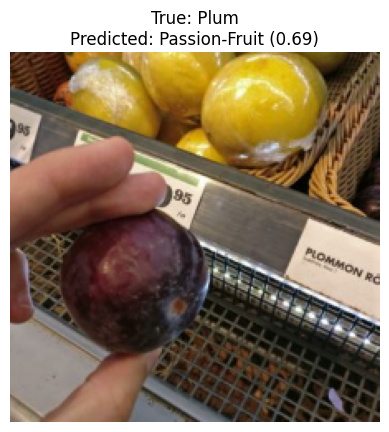

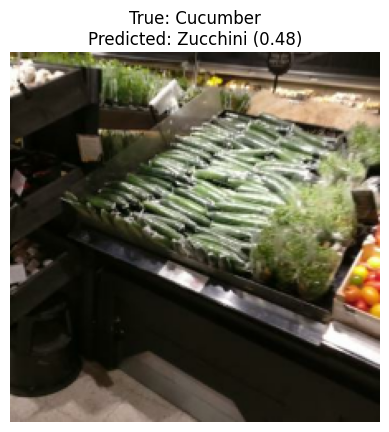

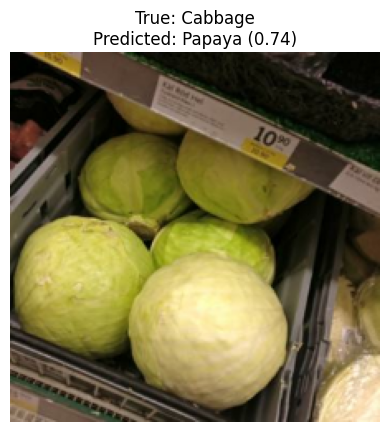

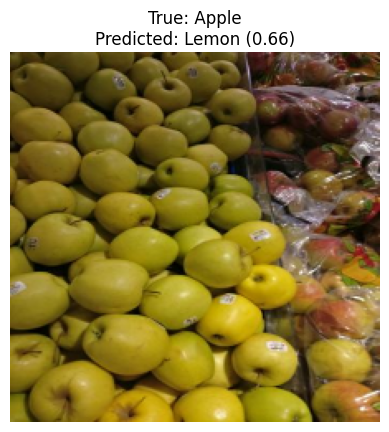

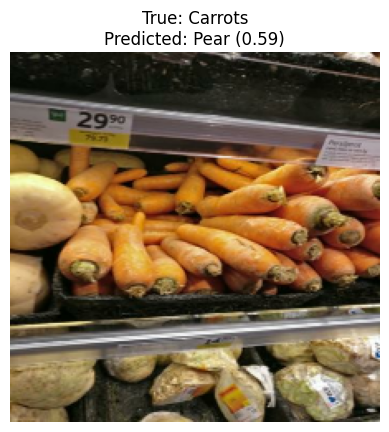

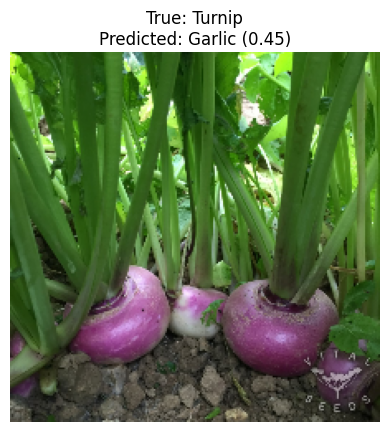

In [23]:
for images, labels in test_set:
    predictions = model.predict(images)
    predicted_class = np.argmax(predictions[0])
    true_class = test_class_names[labels[0]]
    
    if predicted_class != labels[0]: 
        plt.figure()
        plt.imshow(images[0].numpy().astype('uint8'))
        confidence = predictions[0][predicted_class]
        predicted_class_name = test_class_names[predicted_class]
        plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
        plt.axis('off')
        
plt.show()

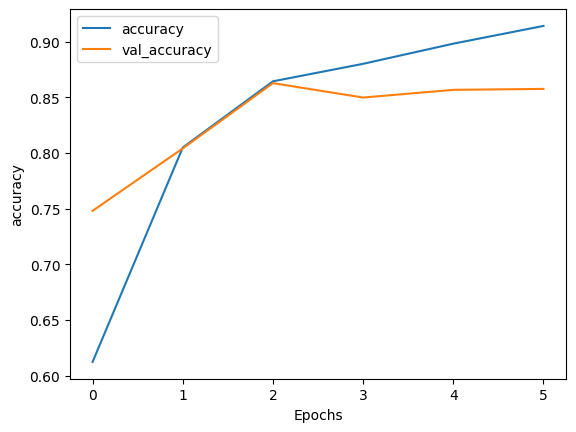

In [24]:
plot_graghs(history, 'accuracy')

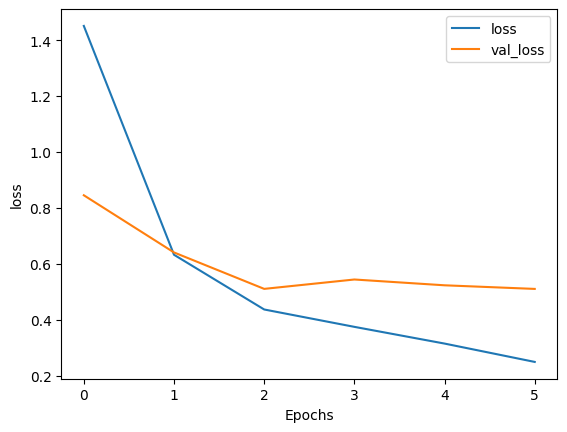

In [25]:
plot_graghs(history, 'loss')

In [26]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import joblib

In [44]:
img_path = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/grocery_store/custom_images/wood.jpg'
img = image.load_img(img_path, target_size=(244, 244))
print(type(img))

<class 'PIL.Image.Image'>


In [50]:
img_path = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/cropped/growing-cucumbers-harvesting-2/10_growing-cucumbers-harvesting-2.png'
img = image.load_img(img_path, target_size=(img_size, img_size))
print(type(img))
img_array = image.img_to_array(img)
img_array = np.array([img_array])

prediction = model.predict(img_array)

predicted_index = np.argmax(prediction)
print(predicted_index)

predicted_class_name = test_class_names[predicted_index]

print(f"Predicted class: {predicted_class_name}")

<class 'PIL.Image.Image'>
1/1 [==============================] - 0s 86ms/step
10
Predicted class: Corn


In [ ]:
img_path = '/Users/arina/study/ds/project/food_recommendation/photo2ingredients_data/cropped/growing-cucumbers-harvesting-2/10_growing-cucumbers-harvesting-2.png'
img = image.load_img(img_path, target_size=(img_size, img_size))
print(type(img))
img_array = image.img_to_array(img)
img_array = np.array([img_array])

prediction = model.predict(img_array)

predicted_index = np.argmax(prediction)
print(predicted_index)

predicted_class_name = test_class_names[predicted_index]

print(f"Predicted class: {predicted_class_name}")

In [46]:
model.save("photo2ingredients.h5")

In [47]:
model = keras.models.load_model("photo2ingredients.h5")

In [31]:
type(model)

keras.engine.functional.Functional

In [32]:
# base_model.trainable = True

In [33]:
# # Compile the model
# model.compile(
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(),
#     optimizer = tf.keras.optimizers.Adam(1e-5),
#     metrics = ["accuracy"])

In [34]:
# initial_epochs = 5
# fine_tune_epochs = 5
# total_epochs =  initial_epochs + fine_tune_epochs

# history_fine = model.fit(training_set,
#                         epochs=total_epochs,
#                         initial_epoch=history.epoch[-1],
#                         validation_data=validation_set)

In [35]:
# plot_graghs(history_fine, 'accuracy')

In [36]:
# plot_graghs(history_fine, 'loss')

In [37]:
predictions = model.predict(test_set, verbose=1)

 6/89 [=>............................] - ETA: 44s

2023-08-15 16:25:59.532260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


32/89 [=========>....................] - ETA: 28s

2023-08-15 16:26:12.318729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


89/89 [==============================] - 48s 515ms/step


In [38]:
# labels_array = np.array([])
# pred_array = np.array([])

# for x, y in test_set.take(1):
#     pred_prob = model.predict(x)
#     labels_array = np.concatenate([labels_array, y])
#     pred_class = np.argmax(pred_prob, axis=1)
#     pred_array = np.concatenate([pred_array, pred_class])    
    
# print("Accuracy On Test Dataset: ", accuracy_score(labels_array, pred_array))

In [39]:
# test_class_names = test_set.class_names

In [40]:
# plt.figure(figsize=(10, 10))
# for images, labels in test_set.take(1):  # Adjust the batch index as needed
#     for i in range(len(images)):
#         plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype('uint8'))
#         predicted_class = np.argmax(predictions[i])
#         confidence = predictions[i][predicted_class]
#         true_class = test_class_names[labels[i]]
#         predicted_class_name = test_class_names[predicted_class]
#         plt.title(f"True: {true_class}\nPredicted: {predicted_class_name} ({confidence:.2f})")
#         plt.axis('off')
# plt.show()

In [41]:
from datetime import datetime

import pandas as pd

In [42]:
now = datetime.now()
d1 = {'Name': [now.minute, now.second]}

df = pd.DataFrame(d1)
print(df)

   Name
0    26
1    42
